#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2018


# Homework 3:  Embeddings + Recommenders

### 100 points [5% of your final grade]

### Due: Monday, April 9 by 11:59pm

*Goals of this homework:* There are two main learning objectives: (i) implement and evaluate a pre-cursor to modern word2vec embeddings; and (ii) implement, evaluate, and improve upon traditional collaborative filtering recommenders.

*Submission Instructions:* To submit your homework, rename this notebook as UIN_hw#.ipynb. For example, this homework submission would be: YourUIN_hw3.ipynb. Submit this notebook via ecampus. Your notebook should be completely self-contained, with the results visible in the notebook. 

*Late submission policy:* For this homework, you may use up to three of your late days, meaning that no submissions will be accepted after Thursday, April 12 at 11:59pm.

# Part 1: Word Embeddings (50 points)
For this first part, we're going to implement a word embedding approach that is a bit simpler than word2vec. The key idea is to look at co-occurrences between center words and context words (somewhat like in word2vec) but without any pesky learning of model parameters.

If you're interested in a deeper treatment of comparing count vs. learned embeddings, take a look at: [Don’t count, predict! A systematic comparison of
context-counting vs. context-predicting semantic vectors](
http://www.aclweb.org/anthology/P14-1023)

## Load the Brown Corpus

The dataset for this part is the (in)famous [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) that is a collection of text samples from a wide range of sources, with over one million unique words. Good for us, you can find the Brown corpus in nltk. *Make sure you have already installed nltk with something like: conda install nltk*

In [1]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to \\filer.cse.tamu.edu\grads\p\
[nltk_data]     pk123\ms_windows\cpsc_redirected\AppData\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Once you have it locally, you can load the dataset into your notebook. You can access the words using brown.words():

In [2]:
from nltk.corpus import brown,stopwords
words_list=brown.words()
#print (len(words_list))

## 1.1 Dataset Pre-processing
OK, now we need to do some basic pre-processing. For this part you should:

* Remove stopwords and punctuation.
* Make everything lowercase.

Then, count how often each word occurs. We will define the 5,000 most  frequent words as your vocabulary (V). We will define the 1,000 most frequent words as our context (C). Include a print statement below to show the top-20 words after pre-processing.

In [4]:
#inp=words_list[:100] #CHANGE THIS INPUT TO words_list[:]
inp=words_list
import re
from string import punctuation
import operator
stop_words=stopwords.words('english')

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)
def data_preprocess(list_words):
    all_words={}
    all_words_dp=[]
    for word in list_words:
        word_lower=word.lower()
        word_lower_sp=strip_punctuation(word_lower)     
        all_words_dp.append(word_lower_sp)
        if word_lower_sp not in stop_words and len(word_lower_sp)>=2:
            #all_words_dp.append(word_lower_sp)
            try:
                all_words[word_lower_sp]+=1
            except:
                all_words[word_lower_sp]=1
    words_sorted=sorted(all_words.items(), key=operator.itemgetter(1),reverse=True)
    vb=words_sorted[:5000]
    cxt=words_sorted[:1000]
    return (all_words_dp,[f[0] for f in vb],[f[0] for f in cxt])

full_text,vocab,context=data_preprocess(inp)

#print (len(vocab),len(context))
print ('Top 20 words are:\n',vocab[:20]) 
#print (len(full_text))

Top 20 words are:
 ['one', 'would', 'said', 'new', 'could', 'time', 'two', 'may', 'first', 'like', 'man', 'even', 'made', 'also', 'many', 'must', 'years', 'af', 'back', 'well']


## 1.2 Building the Co-occurrence Matrix 

For each word in the vocabulary (w), we want to calculate how often context words from C appear in its surrounding window of size 4 (two words before and two words after).

In other words, we need to define a co-occurrence matrix that has a dimension of |V|x|C| such that each cell (w,c) represents the number of times c occurs in a window around w. 

In [5]:
import numpy as np

def get_co_matrix(full_text):
    for index,word in enumerate(full_text):
        check_index=[index-2,index-1,index+1,index+2]
        if word in vocab:
            for new_index in check_index:
                if new_index>0 and new_index<len(full_text):
                    con_word=full_text[new_index]
                    if con_word in context:
                        matrix[vocab.index(word)][context.index(con_word)]+=1

matrix=np.zeros(shape=(5000,1000))                
get_co_matrix(full_text)      

In [6]:
print (matrix)

[[20. 40. 12. ...  0.  2.  2.]
 [40.  2. 34. ...  4.  1.  0.]
 [12. 34.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


## 1.3 Probability Distribution

Using the co-occurrence matrix, we can compute the probability distribution Pr(c|w) of context word c around w as well as the overall probability distribution of each context word c with Pr(c).  

In [7]:
import warnings
warnings.filterwarnings('ignore')
matrix_prob=np.nan_to_num(matrix/(matrix.sum(axis=1).reshape(-1,1)))
print (matrix_prob)
matrix_prior=np.nan_to_num(matrix.sum(axis=0)/matrix.sum().reshape(-1,1))   # length=1000
print (matrix_prior)

[[0.00722282 0.01444565 0.00433369 ... 0.         0.00072228 0.00072228]
 [0.01669449 0.00083472 0.01419032 ... 0.00166945 0.00041736 0.        ]
 [0.01804511 0.05112782 0.00300752 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.01471589 0.0133304  0.0046986  0.00869205 0.00768217 0.00560217
  0.00752271 0.00703726 0.00601321 0.00621164 0.00478364 0.00482616
  0.0046667  0.00497144 0.00508129 0.00511672 0.00549941 0.00395447
  0.00417417 0.00352926 0.00401471 0.00279223 0.00352572 0.00405015
  0.00404306 0.00361076 0.00363911 0.00355052 0.00430882 0.00293396
  0.0036143  0.00336981 0.00327059 0.00290562 0.00325642 0.00359659
  0.00261151 0.00346548 0.00278514 0.00391195 0.00227489 0.003671
  0.00330957 0.00289144 0.00312177 0.00302964 0.00340524 0.00243434
  0.00324579 0

## 1.4 Embedding Representation

Now you can represent each vocabulary word as a |C| dimensional vector using this equation:

Vector(w)= max(0, log (Pr(c|w)/Pr(c)))

This is a traditional approach called *pointwise mutual information* that pre-dates word2vec by some time. 

In [8]:
vector_w=np.log(matrix_prob/matrix_prior)
vector_w[vector_w < 0] = 0
print (vector_w)

[[0.         0.08034576 0.         ... 0.         0.6077893  0.51329845]
 [0.12615109 0.         1.10529624 ... 1.71250099 0.05932768 0.        ]
 [0.20394721 1.34428131 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## 1.5 Analysis

So now we have some embeddings for each word. But are they meaningful? For this part, you should:

- First, cluster the vocabulary into 100 clusters using k-means. Look over the words in each cluster, can you see any relation beween words? Discuss your observations.

- Second, for the top-20 most frequent words, find the nearest neighbors using cosine distance (1- cosine similarity). Do the findings make sense? Discuss.

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, random_state=11).fit_predict(vector_w)
print (kmeans)
from collections import defaultdict
res=defaultdict(list)
for i,value in enumerate(kmeans):
    res[value].append(i)
count=0
for lis in res.values():
    if count==1:  #Increase this count if you want to print more clusters
        break
    print ('Cluster 1 is -',end=' ')
    for index in lis:
        print (vocab[index],end=',')
    print ('  \n\n')
    count+=1

[88 13  7 ... 91 91 25]
Cluster 1 is - one,time,first,long,day,last,every,night,later,next,second,early,week,half,period,following,morning,century,third,late,stage,final,england,fall,earlier,trial,summer,month,sun,afternoon,season,spent,sunday,usual,dinner,previous,died,winter,train,poems,session,november,twice,fourth,saturday,tomorrow,december,victory,friday,ended,tuesday,spend,childhood,decade,nights,spending,wednesday,wedding,starts,preceding,sessions,autumn,  




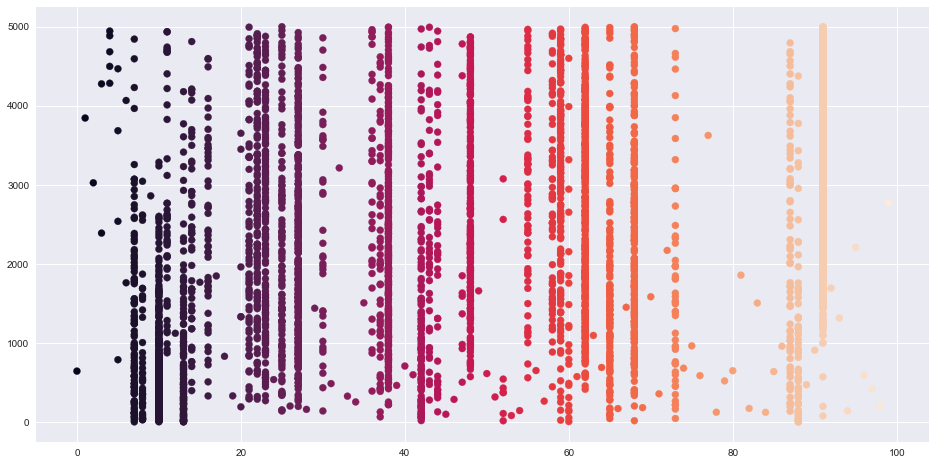

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.scatter(kmeans,range(0,len(kmeans)),c=kmeans)
plt.show()

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity
class Styling:
    bold='\033[1m'
    underline='\033[4m'
    end='\033[0m'
from sklearn.neighbors import NearestNeighbors
neigh=NearestNeighbors(10, metric='cosine')
neigh.fit(vector_w) 
a=neigh.kneighbors(vector_w[:20],6,return_distance=False)
print (Styling.bold+Styling.underline+('Top 20 Words and their neighnors').center(40)+Styling.end)
for row in a:
    for col in row:
        print (vocab[col],end='-')
    print ('')
#print (vocab[a])


Advantages:
1. Overall, these findings makes sense. I can see relation between the words. This metric seem to perform very well on semantic similarity tasks.
2. For 1 neighbour tasks, it can give preety good performance for more frequent words in the vocabulary.
2. PPMI algorithm is also very similar to word2vec.
3. Though PPMI is only an approximation of the original PMI matrix, it still brings the objective function very close to its optimum.

Disadvantage:
1. PPMI vectors are long and sparse.

2. For example,  As Twitter data contains abbreviationsand a number of peculiarities it can be challenging to train effective PMI data. So for this type of data, Word2vec based embeddings can capture the coherence of topics in tweets more robustly and efficiently than the PMI based ones.

3. Dense SVD	embeddings sometimes work better than sparse PPMI matrices at tasks	like word similarity.
  • Denoising:	low-order dimensions may represent unimportant information
  • Truncation may help the	models generalize better to	unseen data.
  • Having	a smaller number of	dimensions may make	it easier for classifiers to properly weigh	the	dimensions for the task.
  • Dense	models	may	do	better	at	capturing	higher	order	cooccurrence.


# Part 2. Collaborative Filtering (50 points)

In this second part, you will implement collaborative filtering on the Netflix prize dataset -- don’t freak out, the provided sample dataset has only ~2000 items and ~28,000 users.

As background, read the paper [Empirical Analysis of Predictive Algorithms for Collaborative Filtering](https://arxiv.org/pdf/1301.7363.pdf) up to Section 2.1. Of course you can read further if you are interested, and you can also refer to the course slides for collaborative filtering.

## 2.1 Load Netflix Data

The dataset is subset of movie ratings data from the Netflix Prize Challenge. Download the dataset from Piazza. It contains a train set, test set, movie file, and README file. The last two files are original ones from the Netflix Prize, however; in this homework you will deal with train and test files which both are subsets of the Netflix training data. Each of train and test files has lines having this format: MovieID,UserID,Rating.

Your job is to predict a rating in the test set using those provided in the training set.

In [12]:
# load the data, then print out the number of ratings, 
# movies and users in each of train and test sets.
import pandas as pd
import numpy as np
def load_data(file_path):
    data = pd.read_csv(file_path, header=None, names=['movieid', 'customerid', 'rating'])
    return data
train=load_data('TrainingRatings.txt')
test=load_data('TestingRatings.txt')

In [13]:
print ('Number of Movies, Users, ratings in Training set are: \n\n', train.count())
print ('\n')
print ('Number of Movies, Users, ratings in Test set are: \n\n', test.count())

Number of Movies, Users, ratings in Training set are: 

 movieid       3255352
customerid    3255352
rating        3255352
dtype: int64


Number of Movies, Users, ratings in Test set are: 

 movieid       100478
customerid    100478
rating        100478
dtype: int64


## 2.2 Implement CF

In this part, you will implement the basic collaborative filtering algorithm described in Section 2.1 of the paper -- that is, focus only on Equations 1 and 2 (where Equation 2 is just the Pearson correlation). You should consider the first 5,000 users with their associated items in the test set. 

Note that you should test the algorithm for a small set of users e.g., 10 users first and then run for 5,000 users. It may take long to run but you won't have memory issues. 

Set k to 0.1. 

In [15]:
def get_cor_matrix(train):
     train2 = train.pivot(index = 'customerid', columns = 'movieid', values = 'rating')
     user_mean = train2.mean(axis = 1)
     cor_matrix = train2.T.corr().fillna(0) # similarity
     return (train2,user_mean,cor_matrix)

train2,user_mean,cor_matrix=get_cor_matrix(train)

In [16]:
print (cor_matrix)

print (test_few)

customerid   7             79            199           481       769      \
customerid                                                                 
7           1.000000  4.134392e-01 -3.221597e-01  3.534827e-03  0.426315   
79          0.413439  1.000000e+00  1.306302e-01  2.299256e-01  0.163849   
199        -0.322160  1.306302e-01  1.000000e+00  1.168887e-01  0.231927   
481         0.003535  2.299256e-01  1.168887e-01  1.000000e+00  0.193114   
769         0.426315  1.638493e-01  2.319267e-01  1.931139e-01  1.000000   
906         0.168116 -3.356915e-02  1.408476e-01 -2.112270e-01  0.130341   
1310        0.176372  3.503992e-01  1.211359e-01  9.335201e-02  0.211414   
1333        0.484590  2.707398e-01 -9.119215e-02  8.303715e-02  0.125565   
1427        0.294586  1.022905e-01  4.870588e-02 -3.035196e-01 -0.019783   
1442        0.522708  2.388051e-01  1.398106e-01  1.588177e-01  0.447416   
1457        0.540801  7.720195e-02 -3.152246e-02 -7.017910e-02  0.550023   
1500        

NameError: name 'test_few' is not defined

In [18]:
print ('Building predictions')
rating_diff = train2.sub(train2.mean(axis=1), axis=0)
user_mean_of_means = user_mean.mean()
users_all = user_mean.index
movies_all = rating_diff.columns
predictions = []
test=test.head(5000)
for i in range(len(test)):
    movie_k, user_i, = [int(test.iat[i,0]), int(test.iat[i,1])]
    # Get user i's mean or assign mean of means
    if user_i in users_all:
        user_i_mean = user_mean.loc[user_i]
    else:
        user_i_mean = user_mean_of_means
    # Obtain all ratings of movie k
    if movie_k in movies_all:
        rating_diff_js = rating_diff.loc[:,movie_k]
        users_j_no_k = rating_diff_js[rating_diff_js.isnull()].index
        # Obtain similarities of user i and users that rated movie k
        w = cor_matrix.loc[user_i,:].copy()
        w.loc[users_j_no_k] = None
        sum_w = w.abs().sum() #replace sum_w with 1000 if you want to set k=0.0001
        # Calculate collaborative rating
        if sum_w != 0:
            coll_rating = (w * rating_diff_js).sum() / sum_w
        else:
            coll_rating = 0
    else:
        coll_rating = 0
    rating_ik = user_i_mean + coll_rating
    # Check bound and round to nearest rating
    predictions.append( round(max(min(rating_ik, 5),1),1) )

print ('Summary results:')
test['predictions'] = predictions

Building predictions
Summary results:


In [23]:

print (test['predictions'])

0       3.1
1       3.2
2       2.6
3       2.8
4       2.8
5       2.9
6       2.9
7       3.8
8       3.5
9       3.1
10      2.8
11      1.0
12      2.7
13      1.0
14      3.7
15      3.2
16      3.1
17      2.9
18      3.1
19      2.9
20      3.8
21      3.2
22      3.9
23      3.1
24      3.9
25      2.8
26      3.8
27      3.2
28      3.4
29      2.4
       ... 
4970    3.5
4971    4.0
4972    3.2
4973    4.3
4974    4.3
4975    3.4
4976    3.6
4977    3.3
4978    3.5
4979    3.2
4980    3.3
4981    4.1
4982    4.0
4983    3.7
4984    3.5
4985    4.2
4986    2.8
4987    5.0
4988    3.4
4989    4.1
4990    3.5
4991    3.8
4992    3.6
4993    3.7
4994    3.9
4995    3.9
4996    3.0
4997    3.7
4998    3.6
4999    3.5
Name: predictions, Length: 5000, dtype: float64


## 2.3 Evaluation 

You should evaluate your predictions using Mean Absolute Error and Root Mean Squared Error. 

In [20]:
# Mean Absolute Error
# Mean Absolute Error
print ('  MAE: ' , round(np.mean(abs(test['rating'] -test['predictions'])),4))

  MAE:  0.693


In [21]:
# Root Mean Squared Error
print ('  RMSE:' , round(np.sqrt( ((test['rating'] -test['predictions'])**2).mean()),4))

  RMSE: 0.8892


## 2.4 Extensions

Given your results in the previous part, can you do better? For this last part you should report on your best attempt at improving MAE and RMSE. Provide code, results, plus a brief discussion on your approach.

In [ ]:
I ran the experiments with k=0.1 and found that results are outside 1-5 range, so changed k to the following to keep the final values in range.
k=1/SUMMATION over (w(a,i)). I have implemented it in cell 2.2 section, if you want to change it to k=0.0001, in the IF statement fix sum_w=10000 which is equivalent to k=0.0001
RMSE is changed 0.92 to 0.88 with this change.
 Other observations:
    1. Choosing 0.1 took my predicted ratings beyond the 1-5 bracket. Choosing 0.0001 had negligible deviation from the mean.
    2. Choosing a different value of k for each test user i.e k = 1/(summation of 'w' across all the users) also resulted in a negligible deviation from the mean. 
    The reason for the negligible deviation is because we are not considering those ratings which have not 
been rated to make our prediction but considering such w's for normalization- this makes the (sigma w) high, thus deviation low.


->Instead of user-user, item-item can give more better results.
item-item outperforms user-user in many cases. This might be because Item's are simpler than users. 
  -> Items belong to small set of genres, users have varied tastes
  -> Item similarity is more meaningful than user similarity
-> Use of latent factor models discussed in class can give better performance.
I noticed that most expensive step in collaborative filteing is to find out K most similar users. O(|U|) where |U| is the size of utility matrix
as there are many manu users, utility matrix will is huge in real time. So too expensive to do at run time.
-> could precompute 
-> Near neighbour search in high dimensions (LSH)
-> Employ Clustering to group users, items in to smaller clusters and there by speed up the process by restricting the search to within a cluster. 
-> Dimensionality reduction methods.
problems: sparsity, cold start, first rater, popularity bias
-> May be remove users who rated very few movies to overcome sparsity issues.(New items/users)
-> popularity bias - Tend to recommedn popular items to everyone in the system as neighbourhood of any item will include popular items.
Hybrid methods to overcome these issues like adding content based methods to collaborative filtering.
 -> we can add Item profiles fornew item problem
 -> Consider Demographics to deal with new user problem.
Other approaches include-
-> combine two or more different recommenders and combine predictions perhaps using a linear model. For example, global baseline+collaborative filtering.
-> add additional bias terms like temporal features, rating deviations etc.. in the cost function.
-> RMSE might penalize a method that does well for high ratingsand badly for others so we can use alternative metric- precision at top k - percentage of predictions in the user's top k withheld ratings.

*Insert discussion here*